In [1]:
%matplotlib widget
import math
import sys
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

pos = Tuple[float, float, float]
Quaternion = Tuple[float, float, float, float]

### Shortest Path
This is one way to create it http://sharif.edu/~ghodsi/papers/mojtaba-cga2007.pdf
But I will use my simple naive way

**Problems**
- We have start point and target point want to know the shortest path between them when there're obstable between theses two points.
- We know all the obstacle location and obstacle is a simple cuboid

**Solution**
- Create a simple visibility Graph
- Use Dijkstra’s Algorithm on it

In [2]:
def eulerto_quaternion(roll: float, pitch: float, yaw: float, **kwargs):
    # https://automaticaddison.com/how-to-convert-euler-angles-to-quaternions-using-python/
    """Convert an Euler angle to a quaternion.

    Args:
        roll (float): The roll (rotation around x-axis) angle in radians.
        pitch (float): The pitch (rotation around y-axis) angle in radians.
        yaw (float): The yaw (rotation around z-axis) angle in radians.

    Returns:
        ndarray: The orientation in quaternion [x,y,z,w] format
    """

    if kwargs.get("degree"):
        roll = math.radians(roll)
        pitch = math.radians(pitch)
        yaw = math.radians(yaw)

    qx = np.sin(roll / 2) * np.cos(pitch / 2) * np.cos(yaw / 2) - np.cos(
        roll / 2
    ) * np.sin(pitch / 2) * np.sin(yaw / 2)
    qy = np.cos(roll / 2) * np.sin(pitch / 2) * np.cos(yaw / 2) + np.sin(
        roll / 2
    ) * np.cos(pitch / 2) * np.sin(yaw / 2)
    qz = np.cos(roll / 2) * np.cos(pitch / 2) * np.sin(yaw / 2) - np.sin(
        roll / 2
    ) * np.sin(pitch / 2) * np.cos(yaw / 2)
    qw = np.cos(roll / 2) * np.cos(pitch / 2) * np.cos(yaw / 2) + np.sin(
        roll / 2
    ) * np.sin(pitch / 2) * np.sin(yaw / 2)

    return np.array([qx, qy, qz, qw])


def rotate_vector_by_quaternion(v: Tuple[float, float, float], q: Quaternion):
    # https://gamedev.stackexchange.com/questions/28395/rotating-vector3-by-a-quaternion
    u = q[:3]
    s = q[3]

    return (
        2.0 * np.dot(u, v) * u
        + np.dot((s * s - np.dot(u, u)), v)
        + 2.0 * s * np.cross(u, v)
    )

### Plotting Area
KIZ, KOZ information

In [3]:
def points_from(pmin: pos, pmax: pos):
    xmin, ymin, zmin = pmin
    xmax, ymax, zmax = pmax

    """
    return point from 
    .      →      .

    ↑             ↓

    .      ←      .

    and change to next layer 
    """
    return [
        (xmin, ymin, zmin),
        (xmax, ymin, zmin),
        (xmax, ymin, zmax),
        (xmin, ymin, zmax),
        (xmin, ymax, zmin),
        (xmax, ymax, zmin),
        (xmax, ymax, zmax),
        (xmin, ymax, zmax),
    ]


def plot_scatter(ax: plt.Axes, point: np.ndarray, **kwargs):
    xdata = np.array(point[:, 0])
    ydata = np.array(point[:, 1])
    zdata = np.array(point[:, 2])

    size = 4
    color = "black"

    if kwargs.get("size"):
        size = kwargs.get("size")

    if kwargs.get("color"):
        color = kwargs.get("color")

    if kwargs.get("text"):
        # label first scatter point, hacky way
        ax.text(xdata[0], ydata[0], zdata[0], kwargs.get("text"))

    ax.scatter(xdata, ydata, zdata, color=color, marker="o", s=size)


def plot_filled_rect(ax: plt.Axes, P: np.ndarray, color: str, **kwargs):
    # verts is just a collection of points in each side
    verts = [
        [P[0], P[1], P[2], P[3]],
        [P[4], P[5], P[6], P[7]],
        [P[0], P[1], P[5], P[4]],
        [P[3], P[2], P[6], P[7]],
        [P[0], P[3], P[7], P[4]],
        [P[1], P[2], P[6], P[5]],
    ]

    plot_scatter(ax, P)
    ax.add_collection(
        Poly3DCollection(verts, facecolor=color, alpha=0.1, linewidths=1, edgecolor="r")
    )

'\nmid_p = [10.876214285714285, -8.5, 4.97063]\nm2 = [11.0067, -9.44819, 5.186407142857143]\n\nax.plot([10.71, mid_p[0]], [-7.7, mid_p[1]], [4.48, mid_p[2]])\nax.plot([mid_p[0], m2[0]], [mid_p[1], m2[1]], [mid_p[2], m2[2]])\nax.plot([m2[0], 11.27460], [m2[1], -9.92284], [m2[2], 5.29881])\n'

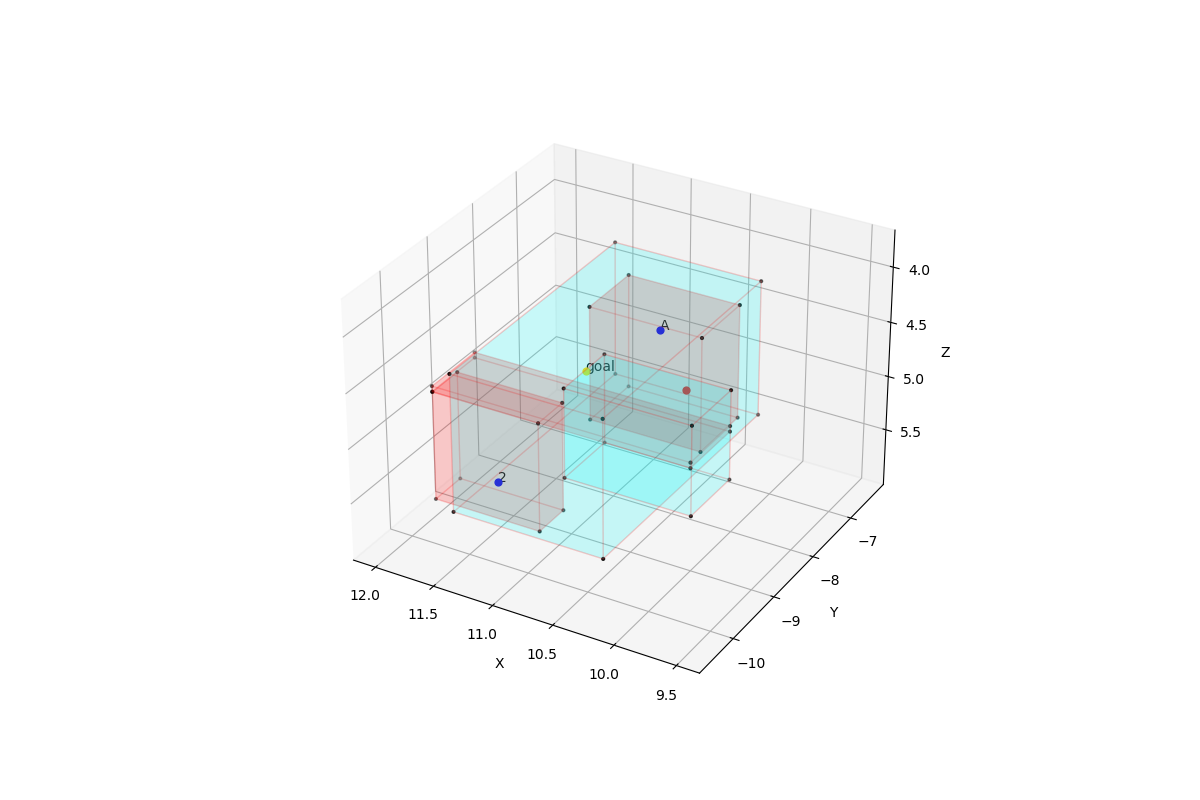

In [7]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection="3d")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.invert_zaxis()
ax.invert_xaxis()

kiz = np.array(points_from([10.3, -10.2, 4.32], [11.55, -6.4, 5.57]))
kiz2 = np.array(points_from([9.5, -10.5, 4.02], [10.5, -9.6, 4.8]))
koz1 = np.array(points_from([9.8673, -9.18813, 3.81957], [10.7673, -8.28813, 4.81957]))
koz2 = np.array(points_from([9.8585, -9.4500, 4.82063], [12.0085, -8.5000, 4.87063]))
koz3 = np.array(points_from([11.1067, -9.44819, 4.87385], [12.0067, -8.89819, 5.87385]))

plot_filled_rect(ax, kiz, "cyan")
plot_filled_rect(ax, kiz2, "cyan")
plot_filled_rect(ax, koz1, "red")
plot_filled_rect(ax, koz2, "red")
plot_filled_rect(ax, koz3, "red")

# starting point
plot_scatter(ax, np.array([(10.76150, -6.88490, 5.31647)]), color="red", size=24)


# point-A

plot_scatter(
    ax, np.array([(10.71000, -7.70000, 4.48000)]), color="blue", size=24, text="A"
)


# point 2
plot_scatter(
    ax, np.array([(11.27460, -9.92284, 5.29881)]), color="blue", size=24, text="2"
)

# goal point

plot_scatter(
    ax,
    np.array([(11.27460, -7.89178, 4.96538)]),
    color="gold",
    size=24,
    text="goal",
)


# path planning
"""
mid_p = [10.876214285714285, -8.5, 4.97063]
m2 = [11.0067, -9.44819, 5.186407142857143]

ax.plot([10.71, mid_p[0]], [-7.7, mid_p[1]], [4.48, mid_p[2]])
ax.plot([mid_p[0], m2[0]], [mid_p[1], m2[1]], [mid_p[2], m2[2]])
ax.plot([m2[0], 11.27460], [m2[1], -9.92284], [m2[2], 5.29881])
"""

### Graph Construction

distance function from https://www.engineeringtoolbox.com/distance-relationship-between-two-points-d_1854.html


In [5]:
class Point:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __repr__(self):
        return f"({self.x}, {self.y}, {self.z})"

    def distance_to(self, p):
        return math.sqrt(
            (pow(p.x - self.x, 2) + pow(p.y - self.y, 2) + pow(p.z - self.z, 2))
        )

In [6]:
p1 = Point(10.71000, -7.70000, 4.48000)
p2 = Point(11.27460, -9.92284, 5.29881)
p1.distance_to(p2)

2.4352085417269707

#### Visibility Graph
Our visibility graph will be an Undirected Weighted Graph

In [7]:
import copy


class VisGraph:
    def __init__(self):
        self.vertices = []
        self.edges = dict()

    def add_vertex(self, v):
        if v not in self.vertices:
            self.vertices.append(v)

    def add_edge(self, v, u, weight):
        if v not in self.vertices or u not in self.vertices:
            return
        if v not in self.edges:
            self.edges[v] = set()
        if u not in self.edges:
            self.edges[u] = set()

        self.edges[v].add((u, weight))
        self.edges[u].add((v, weight))

    def min_u(self, Q, dist):
        min_u = 1e7
        res = None
        for u in Q:
            if dist[u] < min_u:
                min_u = dist[u]
                res = u
        return res

    def shortest_path(self, src, target):
        dist = {}
        prev = {}
        Q = []
        for v in self.vertices:
            dist[v] = 1e7
            prev[v] = None
            Q.append(v)

        dist[src] = 0

        while len(Q) != 0:
            u = self.min_u(Q, dist)
            if u == target:
                break
            Q.remove(u)

            for v in self.edges[u]:
                if v[0] in Q:
                    alt = dist[u] + v[1]
                    if alt < dist[v[0]]:
                        dist[v[0]] = alt
                        prev[v[0]] = u

        S = []
        u = target
        distance = dist[u]
        if prev[u] != None or u == src:
            while u != None:
                S.insert(0, u)
                u = prev[u]

        return S, distance

**Add all points from KOZs that should be in visibility graph**

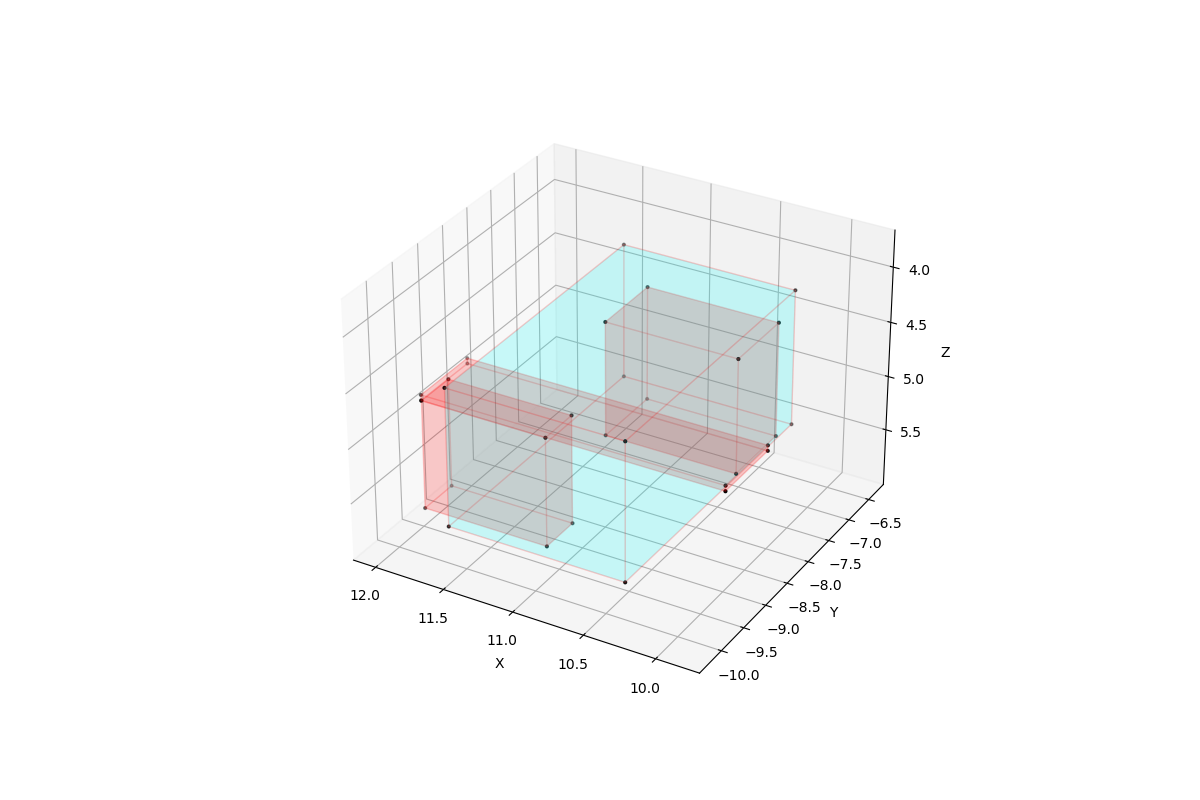

In [8]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection="3d")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.invert_zaxis()
ax.invert_xaxis()

kiz = np.array(points_from([10.3, -10.2, 4.32], [11.55, -6.4, 5.57]))
koz1 = np.array(points_from([9.8673, -9.18813, 3.81957], [10.7673, -8.28813, 4.81957]))
koz2 = np.array(points_from([9.8585, -9.4500, 4.82063], [12.0085, -8.5000, 4.87063]))
koz3 = np.array(points_from([11.1067, -9.44819, 4.87385], [12.0067, -8.89819, 5.87385]))
plot_filled_rect(ax, kiz, "cyan")
plot_filled_rect(ax, koz1, "red")
plot_filled_rect(ax, koz2, "red")
plot_filled_rect(ax, koz3, "red")

In [9]:
def add_scatter(ax, p):
    ax.scatter3D(p[:, 0], p[:, 1], p[:, 2], c="blue")

**KOZ1** \
offset x_axis by 0.1 \
`10.7673 + 0.1`

In [10]:
# use KIZ zmin
koz1_edge1 = np.linspace([10.8673, -8.28813, 4.42], [10.8673, -8.28813, 4.81957])
koz1_edge2 = np.linspace([10.8673, -9.18813, 4.42], [10.8673, -9.18813, 4.81957])

add_scatter(ax, koz1_edge1)
add_scatter(ax, koz1_edge2)

**KOZ2** \
offset z_axis by 0.1 \
`4.82063 - 0.1` \
`4.87063 + 0.1`

In [11]:
# points_from([9.8585, -9.4500, 4.82063], [12.0085, -8.5000, 4.87063])
# kiz = np.array(points_from([10.3, -10.2, 4.32], [11.55, -6.4, 5.57]))

koz2_edge1 = np.linspace([10.7673, -8.5000, 4.72063], [11.55, -8.5000, 4.72063])
koz2_edge2 = np.linspace([10.7673, -9.4500, 4.72063], [11.55, -9.4500, 4.72063])

koz2_edge3 = np.linspace([10.3, -8.5000, 4.97063], [11.1067, -8.5000, 4.97063])
koz2_edge4 = np.linspace([10.3, -9.4500, 4.97063], [11.1067, -9.4500, 4.97063])

add_scatter(ax, koz2_edge1)
add_scatter(ax, koz2_edge2)
add_scatter(ax, koz2_edge3)
add_scatter(ax, koz2_edge4)

**KOZ3** \
offset x_axis by 0.1

In [12]:
# points_from([11.1067, -9.44819, 4.87385], [12.0067, -8.89819, 5.87385])

koz3_edge1 = np.linspace([11.0067, -8.89819, 4.87385], [11.0067, -8.89819, 5.57])
koz3_edge2 = np.linspace([11.0067, -9.44819, 4.87385], [11.0067, -9.44819, 5.57])

add_scatter(ax, koz3_edge1)
add_scatter(ax, koz3_edge2)

vertices_toadd = np.concatenate(
    (
        koz1_edge1,
        koz1_edge2,
        koz2_edge1,
        koz2_edge2,
        koz2_edge3,
        koz2_edge4,
        koz3_edge1,
        koz3_edge2,
    )
)

**Actual Graph**

In [13]:
vs = VisGraph()
# Point A
p_a = Point(10.71000, -7.811971, 4.48000)
vs.add_vertex(p_a)

# Point 2
p_2 = Point(11.27460, -9.92284, 5.29881)
vs.add_vertex(p_2)

# Point goal
p_g = Point(11.27460, -7.89178, 4.96538)
vs.add_vertex(p_g)

**Adding vertex**

In [14]:
for p in vertices_toadd:
    vs.add_vertex(Point(p[0], p[1], p[2]))
len(vs.vertices)

403

**Utillity fucntion to check if line is intercent with any KOZ**

In [15]:
def is_intersect(u, v, x, y, z):
    """
    https://math.stackexchange.com/questions/1164639/condition-for-line-intersecting-cuboid
    u, v: Point -> point of line segment.
    x, y, z: [min, max] -> pos of cuvoid.
    """
    t = [[0, 1]]

    if v.x > u.x:
        t1 = [[(x[0] - u.x) / (v.x - u.x), (x[1] - u.x) / (v.x - u.x)]]
    elif v.x < u.x:
        t1 = [[(x[1] - u.x) / (v.x - u.x), (x[0] - u.x) / (v.x - u.x)]]
    else:
        # t can be any value
        t1 = [[-sys.maxsize, sys.maxsize]]

    if v.y > u.y:
        t2 = [[(y[0] - u.y) / (v.y - u.y), (y[1] - u.y) / (v.y - u.y)]]
    elif v.y < u.y:
        t2 = [[(y[1] - u.y) / (v.y - u.y), (y[0] - u.y) / (v.y - u.y)]]
    else:
        t2 = [[-sys.maxsize, sys.maxsize]]

    if v.z > u.z:
        t3 = [[(z[0] - u.z) / (v.z - u.z), (z[1] - u.z) / (v.z - u.z)]]
    elif v.z < u.z:
        t3 = [[(z[1] - u.z) / (v.z - u.z), (z[0] - u.z) / (v.z - u.z)]]
    else:
        t3 = [[-sys.maxsize, sys.maxsize]]

    t_concat = np.concatenate((t, t1, t2, t3))

    max_lw = max(t_concat[:, 0])
    min_up = min(t_concat[:, 1])

    return max_lw < min_up

In [16]:
def in_cuboid(u, v):
    # we will make all koz a little bit bigger (0.1)
    offset = 0.05

    # koz1 [9.8673, -9.18813, 3.81957], [10.7673, -8.28813, 4.81957]
    in_koz1 = is_intersect(
        u,
        v,
        [9.8673 - offset, 10.7673 + offset],
        [-9.18813 - offset, -8.28813 + offset],
        [3.81957 - offset, 4.81957 + offset],
    )

    # koz2 [9.8585, -9.4500, 4.82063], [12.0085, -8.5000, 4.87063]
    in_koz2 = is_intersect(
        u,
        v,
        [9.8585 - offset, 12.0085 + offset],
        [-9.4500 - offset, -8.5000 + offset],
        [4.82063 - offset, 4.87063 + offset],
    )

    # koz3 [11.1067, -9.44819, 4.87385], [12.0067, -8.89819, 5.87385]
    in_koz3 = is_intersect(
        u,
        v,
        [11.1067 - offset, 12.0067 + offset],
        [-9.44819 - offset, -8.89819 + offset],
        [4.87385 - offset, 5.87385 + offset],
    )

    return in_koz1 or in_koz2 or in_koz3

**Adding edges**

In [17]:
for u in vs.vertices:
    for v in vs.vertices:
        if u != v and not in_cuboid(u, v):
            vs.add_edge(u, v, u.distance_to(v))

In [18]:
vs.shortest_path(p_a, p_2)

([(10.71, -7.811971, 4.48),
  (10.892677551020409, -8.5, 4.97063),
  (11.0067, -9.44819, 5.186407142857143),
  (11.2746, -9.92284, 5.29881)],
 2.400163801145352)

In [19]:
p_a.distance_to(p_2)

2.333450430427225

In [20]:
vs.shortest_path(p_2, p_g)

([(11.2746, -9.92284, 5.29881),
  (11.0067, -9.44819, 5.1722),
  (11.073773469387755, -8.5, 4.97063),
  (11.2746, -7.89178, 4.96538)],
 2.1717826624479417)

In [21]:
p_2.distance_to(p_g)

2.058246896876078